# Octane applicability domain

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from rdkit import Chem
from rdkit.Chem import AllChem,Draw

'''custom modules'''
from filter_data import Select_descriptors
from process_data import Scalar
from simmilarity import Partition
from train import Model
import wandb
import pickle
import os

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [3]:
df.head(5)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,boiling_point_K
0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,...,14,12,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13,0.9,390.81
1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,...,6,4,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2,-0.1,351.44
2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,...,2,1,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2,-0.5,337.85
3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,Training,100.25,...,10,8,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7,0.3,370.35
4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,NaN,NaN,...,30,31,2.361111,1.666667,NaN,118.17,no alternative,42,2.7,384.62


### 1. Data preprocessing

In [4]:
### 1.1 Remove columns with missing values
misssing_val_cols = df.columns[df.isnull().any()]
print('Columns with missing values are = {}'.format(list(misssing_val_cols)))

Columns with missing values are = ['Compound Name', 'TARGET', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON', 'dev', 'boiling_point_K']


In [5]:
### 1.2 Remove columns with irrelevant to modelling values
df_ = df.drop(misssing_val_cols,axis=1)

irrelevant_to_pred_columns = ['PubChem','ron_choice']

df_ = df_.drop(irrelevant_to_pred_columns,axis=1)

In [6]:
print('final dataset sie = {}'.format(df_.shape))

final dataset sie = (492, 879)


### 2. Split dataset (standartization must be applied on train set only )

In [7]:
seed = 42 # Fix random seed to make split reproducible (experiment must be reproducible)

X_train, X_test, y_train, y_test = train_test_split(df_.drop('y',axis=1), df_['y'], test_size=0.2, random_state=seed)

In [8]:
print('Train dataset size = {}'.format(X_train.shape))
print('Test dataset size = {}'.format(X_test.shape))

Train dataset size = (393, 878)
Test dataset size = (99, 878)


In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

In [10]:
# Normilise features, so varince threshold can be applied
sc         = Scalar('minmax')

# Wrapper feature selector
'''
wrapper    = sfs(SVR(gamma='auto'),
              n_features_to_select=50,
              scoring='neg_mean_squared_error',
              cv=5)
'''
#wrapper    = SelectFromModel(RandomForestRegressor(n_estimators=300),max_features=50)
# Applies varience threshold, removes high correlated features, removes higly skewed vars and applies wrapper in the end.

'''
wrapper    = sfs(RandomForestRegressor(n_estimators=300),n_features_to_select=50,
                 scoring='neg_mean_squared_error',
                 cv=5)
'''
Filter_    = Select_descriptors(0.01,0.95,None,None)

sc.fit(X_train)

In [11]:
#X_train  = Filter_.transform(sc.transform(X_train),y_train)

In [12]:
!wandb login aa5cce262080e13cecdbb604a81606ee881a7af9

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\zcemg08/.netrc


In [13]:
config = dict (
    dataset = 'Octane',
    size = 492,
    model = "GBM",
    var_selection = 'wrapper_linear',
    AD = "Tanimoto",
)

In [14]:
wandb.init(project="applicability_domain", entity="zcemg08",config=config)

wandb: Currently logged in as: zcemg08. Use `wandb login --relogin` to force relogin


In [15]:
with open(r'C:\Users\zcemg08\PycharmProjects\biofuels\saved_results\octane_features2.pickle', 'rb') as handle:
    VARIABLES = pickle.load(handle)

df2 = X_train['SMILES']
df2.reset_index(drop=True, inplace=True)
df3 = sc.transform(X_train)[VARIABLES[config['var_selection']]]

X_train = pd.concat([df2,df3],axis=1)

In [16]:
ml_model = Model(config['model'],X_train,y_train,200)

In [17]:
model_   = ml_model.build_model()

[I 2022-08-01 18:29:05,694] A new study created in memory with name: no-name-18c32963-5913-4536-a82f-c8446e18e054


KeyboardInterrupt: 

In [18]:
## save trained model

with open(os.path.join(wandb.run.dir, 'model.pickle'), 'wb') as handle:
    pickle.dump(model_, handle, protocol=pickle.HIGHEST_PROTOCOL)

wandb.save(os.path.join(wandb.run.dir, 'model.pickle'))

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['C:\\Users\\zcemg08\\PycharmProjects\\biofuels\\wandb\\run-20220801_181353-2n3ntbku\\files\\model.pickle',
 'C:\\Users\\zcemg08\\PycharmProjects\\biofuels\\wandb\\run-20220801_181353-2n3ntbku\\files\\model.pickle']

In [16]:
# load trained model

directory = r'C:\\Users\\zcemg08\\PycharmProjects\\biofuels\\wandb\\run-20220801_181353-2n3ntbku\\files\\model.pickle'


with open(directory, 'rb') as handle:
    model_ = pickle.load(handle)

### Performance on the test set

In [17]:
# Log test set results

y_pred_test = model_.predict(sc.transform(X_test)[X_train.columns[1:]])
mae         = np.abs(y_test.values-y_pred_test)

def mol_image(smiles):

    molecule = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(molecule)
    AllChem.GenerateDepictionMatching2DStructure(molecule, molecule)
    pil_image = Draw.MolToImage(molecule, size=(300, 300))

    return pil_image

error = y_test.values-y_pred_test

test_result = [[x,wandb.Image(mol_image(x)),y,z,k,l] for x,y,z,k,l in zip(X_test['SMILES'].values,y_test.values,y_pred_test,error,np.abs(error))]
test_table  = wandb.Table(data=test_result, columns=['SMILES','Molecule','y_true','y_pred','error','abs_error'])

wandb.log({'Test set results':test_table})

wandb.log({'residuals ': wandb.plot.histogram(test_table, "abs_error",
                                              title="Residuals Distribution")})

wandb.log({'mae_test':round(mean_absolute_error(y_pred_test,y_test),2),
           'r2_test':round(r2_score(y_pred_test,y_test),2),
           'mape_test':round(mean_absolute_percentage_error(y_pred_test,y_test),2)})


wandb.log({"pred_vs_expected" : wandb.plot.scatter(test_table,
                                                   "y_true", "y_pred")})

### Applicability domain

In [18]:
def means(x):
    vals = []
    for key, value in x.items():
        if value['error'] is not None:
            vals.append(value['error'].mean())
    return vals


def plot_boxplot(errors):

    fig, ax = plt.subplots(figsize=(10,7))



    means_ = np.array([errors[x]['error'] for x in [0.01,0.2,0.4,0.6,0.8]])
    fractions = [round(len(errors[x]['error'])/len(X_test),2) for x in [0.01,0.2,0.4,0.6,0.8]]

    range_x  = np.arange(1,len(means_)+1)
    range_y  = [np.mean(x) for x in means_]

    ax.scatter(range_x, range_y, color='r')
    for i, txt in enumerate(fractions):
        ax.annotate(txt, (range_x[i]+0.27, range_y[i]-0.25))
    ax.boxplot(means_,labels=[0.01,0.2,0.4,0.6,0.8])
    ax.set_xlabel('% Outliers ')
    ax.set_ylabel('MAE')

Calculate

In [19]:
range_  =  sorted(list(np.linspace(0.001,0.96,20)) + [0.01,0.2,0.4,0.6,0.8])
P      =  Partition(X_train,sc.transform(X_test),mae,config['AD'],range_)
errors =  P.calculate()

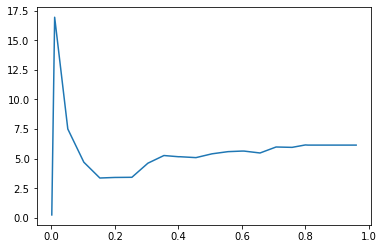

In [20]:
plt.plot(range_,means(errors))

In [33]:
'''Error vs contamination factor'''

data = [[x, y] for (x, y) in zip(range_, means(errors))]
table = wandb.Table(data=data, columns = ["v", "error"])
wandb.log({"error vs v" : wandb.plot.line(table, "v", "error",
                                                 title="mae vs v")})

In [21]:
'''Error vs distance'''

data = [[x, y] for (x, y) in zip(range_, means(errors))]
table = wandb.Table(data=data, columns = ["dist", "error"])
wandb.log({"error vs v" : wandb.plot.line(table, "dist", "error",
                                          title="mae vs dist")})